In [1]:
import csv
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests as multi
from statsmodels.stats.multicomp import MultiComparison

 # Make a dictionary with orthogroups as keys and the number of genes from that orthogroup in each species as the values in a list
  ## Only analyze those orthogroups that showed some difference in gene copy number (see `Gene family expansions and contractions in section Fumigati` in lab notebook)
   ## When making the dictionary, convert all the gene numbers to integers
   ### Python will originally import them as strings

In [2]:
# open the file and make an initial dictionary that has orthogroups as keys and all the gene numbers as values
#NOTE: this CSV file can NOT have a header
with open('../only_changes.csv') as mainfilehandle:
    reader = csv.reader(mainfilehandle, delimiter=',')
    l = list(reader)
    d = {row[0]:row[1:] for row in l}

# make an empty dictionary that will eventually contain orthogroups and gene numbers as integers (and not strings)
dInt = {}

#for every key in the initial dictionary...
for k in d:
    
    #make a new key in the "integer" dictionary that is the key you're currently looping on
    dInt[k] = []
    
    #for every value with that key
    for v in d[k]:
        
        #convert the number to an integer
        new = int(v)
        
        #and append it into the "integer" dictionary
        dInt[k].append(new)

 # Do the ANOVA and make a list with the unadjusted p-values

In [3]:
#make an empty dictionary that will hold orthogroups as keys and \
#the unadjusted p-value resulting from the ANOVA for that orthogroup as the value

dUnadjPvalues = {}

#make an empty list that will contain the unadjusted p-values in the same order as the dictionary
unadjPvalues = []

#for every key (orthogroup) in the "integer" dictionary...
for k in dInt:
    
    #make three lists that contain the number of genes from each class of species pathogenicity
    high = [dInt[k][1], dInt[k][5], dInt[k][6], dInt[k][7], dInt[k][8]]
    medium = [dInt[k][10], dInt[k][11], dInt[k][12], dInt[k][15], dInt[k][16]]
    low = [dInt[k][0], dInt[k][2], dInt[k][3], dInt[k][4], dInt[k][9], dInt[k][13], dInt[k][14], dInt[k][17]]
    
    #calculate the ANOVA and convert the result to a string
    anova = str(stats.f_oneway(high, medium, low))
    
    #split up the ANOVA result, using "=" as the delimiter
    pvalue1 = anova.split("=")
    
    #make a variable that contains everything after the second "=" (aka the p-value and a ")" that you don't want)\
    #and split it based on ')'
    pvalue2 = pvalue1[2].split(')')
    
    #take just the p-value and convert it to a float
    pvalue3 = float(pvalue2[0])
    
    #add that p-value to the unadjusted p-values list and the unadjsuted p-values dictionary
    unadjPvalues.append(pvalue3)
    dUnadjPvalues[k] = pvalue3

/Users/MattMead/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: divide by zero encountered in double_scalars
  f = msb / msw


 # Adjust the p-values using the Benjamini-Hochberg method

In [4]:
adjResult = multi(unadjPvalues, method = 'fdr_bh')

 # Make a dictionary that contains orthogroups as keys and adjusted p-values as values

In [5]:
#make an empty dictionary
dAdjPvalues = {}

#make a variable that will contain the place of the key you're on in the dictionary\
#since the adjusted p-value list is in the same order as the unadjusted p-value dictionary, this will make sure that\
#the orthogroups are assigned the right adjusted p-value
number = 0

#for every key in the unadjusted p-values dictionary
for k in dUnadjPvalues:
    
    #add that key to the new, adjusted p-values dictionary with an associated value that is the correct, adjusted p-value
    #adjResult[1] is needed because the first part of the adjusted p-value result is an array of booleans for some reason
    dAdjPvalues[k] = adjResult[1][number]
    
    #add one to the counting variable so that you stay in the proper order of the unadjusted p-value dictionary
    number += 1

 # Before adjusting the p-values, how many orthogroups had significantly different copy numbers? 

In [6]:
#make a variable that will contain the total number of orthogroups with unadjusted p-values less than 0.05
unAdjTotal = 0

#for every key in the unadjsuted p-values dictionary...
for k in dUnadjPvalues:
    
    #if the unadjusted p-value for that key (orthogroup) is less than 0.05...
    if dUnadjPvalues[k] <0.05:
        
        #add one to the variable containing the number of orthogroups with p<0.05
        unAdjTotal +=1

#print the total number of orthogroups with an unadjusted p-value less than 0.05
print("Unadjusted total:" + " " + str(unAdjTotal))

Unadjusted total: 1991


 # After adjusting the p-values, how many orthogroups had significantly different copy numbers?

In [7]:
#make a variable that will contain the total number of orthogroups with adjusted p-values less than 0.05
AdjTotal = 0

#for every key in the adjusted p-values dictionary...
for k in dAdjPvalues:
    
    #if the adjusted p-value for that key (orthogroup) is less than 0.05...
    if dAdjPvalues[k] <0.05:
        
        #add one to the variable containing the number of orthogroups with p<0.05
        AdjTotal +=1

#print the total number of orthogroups with an unadjusted p-value less than 0.05
print("Adjusted total:" + " " + str(AdjTotal))

Adjusted total: 512


 # Hmm... going from 1,991 significant orthogroups to 512 seems like a huge drop. What does the "worst" orthogroup look like from the unadjusted list?

 ## Make a boxplot of the copy numbers for the three pathogenicity levels

 ### First need to know which is the "worst" orthogroup from the unadjusted list

In [8]:
#make a dictionary that will contain only the orthogroups with unadjusted p-values less than 0.05
dUnadjP05 = {}

#for every key (orthogroup) in the original unadjusted p-values dictionary...
for k in dUnadjPvalues:
    
    #if the unadjusted p-value for that key (orthogroup) is less than 0.05...
    if dUnadjPvalues[k] < 0.05:
        
        #add the orthogroup and the p-value to the new unadjusted p-value <0.05 dictionary 
        dUnadjP05[k] = dUnadjPvalues[k]

#sort the unadjusted p-value (<0.05) dictionary by the values
sorted_UnadjP05 = sorted(dUnadjP05.items(), key=lambda kv: kv[1])

#reverse the order so that the biggest p-values are at the top
sorted_UnadjP05.reverse()

#show the first five
sorted_UnadjP05[:5]

[('453', 0.049011849811459646),
 ('8836', 0.04891910048559436),
 ('7509', 0.04891910048559436),
 ('7508', 0.04891910048559436),
 ('7507', 0.04891910048559436)]

 ### Make the boxplot

In [9]:
import pandas as pd
#make seaborn make the plot if you execute the code after putting a semi-colon at the end of the line
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

 #### Make this a function so that it's easier to call whenever I want to make a boxplot of an orthogroup I'm interested in

In [10]:
#orthogroup will be the only parameter
def boxplot(orthogroup):
    #make a list that is the pathogenicity levels of the species in the order that they will be in the dataframe
    pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium',\
                 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
    #make a list that is the strains
    strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
              
    
    #make a list of the gene counts in the same order as the pathogenicity list
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
          dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
          dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
              dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]

    #make a pandas dataframe with strain, Gene_Count, and a Pathogenicity_Level column
    df = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count','Pathogenicity_Level'])
    
    print(df)
    
    sns.boxplot(x="Pathogenicity_Level", y="Gene_Count", data=df).set_title(orthogroup);

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           2                high
1      A_fumigatus_12-750544           2                high
2          A_fumigatus_A1163           2                high
3          A_fumigatus_Af293           2                high
4         A_fumigatus_F16311           2                high
5        A_lentulus_IFM54703           2              medium
6   A_novofumigatus_IBT16806           2              medium
7        A_udagawae_IFM46973           2              medium
8    A_viridinutans_FRR_0576           2              medium
9    A_thermomutatus_HMRAF39           2              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           1                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           2                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

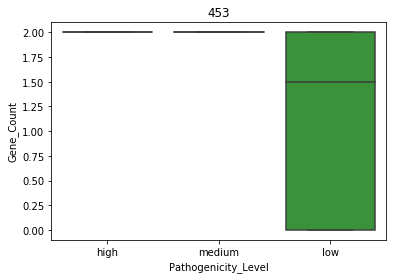

In [11]:
boxplot('453')

 # The "worst" unadjusted p-value orthogroup does look complicated/messy

 # What does the "last" orthogroup left out when using the adjusted p-value list look like?

 ## Show all the unadjusted p-values from worst to best

In [12]:
for i in sorted_UnadjP05:
    print(i)

('453', 0.049011849811459646)
('8836', 0.04891910048559436)
('7509', 0.04891910048559436)
('7508', 0.04891910048559436)
('7507', 0.04891910048559436)
('7506', 0.04891910048559436)
('7505', 0.04891910048559436)
('7504', 0.04891910048559436)
('7503', 0.04891910048559436)
('7502', 0.04891910048559436)
('7500', 0.04891910048559436)
('7498', 0.04891910048559436)
('7497', 0.04891910048559436)
('7496', 0.04891910048559436)
('7495', 0.04891910048559436)
('7493', 0.04891910048559436)
('7492', 0.04891910048559436)
('7490', 0.04891910048559436)
('7487', 0.04891910048559436)
('7486', 0.04891910048559436)
('7485', 0.04891910048559436)
('7482', 0.04891910048559436)
('7481', 0.04891910048559436)
('7478', 0.04891910048559436)
('7477', 0.04891910048559436)
('7474', 0.04891910048559436)
('7472', 0.04891910048559436)
('7469', 0.04891910048559436)
('7468', 0.04891910048559436)
('7467', 0.04891910048559436)
('7466', 0.04891910048559436)
('7465', 0.04891910048559436)
('7464', 0.04891910048559436)
('7463', 0

('9362', 0.003146333097009481)
('9357', 0.003146333097009481)
('9356', 0.003146333097009481)
('9355', 0.003146333097009481)
('9354', 0.003146333097009481)
('9342', 0.003146333097009481)
('9233', 0.003146333097009481)
('9218', 0.003146333097009481)
('9215', 0.003146333097009481)
('9214', 0.003146333097009481)
('9213', 0.003146333097009481)
('9212', 0.003146333097009481)
('9186', 0.003146333097009481)
('7093', 0.003146333097009481)
('7066', 0.003146333097009481)
('7051', 0.003146333097009481)
('9598', 0.0031463330970094754)
('9594', 0.0031463330970094754)
('9571', 0.0031463330970094754)
('9563', 0.0031463330970094754)
('9524', 0.0031463330970094754)
('9502', 0.0031463330970094754)
('597', 0.0031463330970094698)
('590', 0.0031463330970094698)
('375', 0.0031463330970094698)
('8197', 0.0030098295696531544)
('8196', 0.0030098295696531544)
('8192', 0.0030098295696531544)
('8187', 0.0030098295696531544)
('8185', 0.0030098295696531544)
('8183', 0.0030098295696531544)
('8176', 0.0030098295696531

 ## Make a dataframe that is all the adjusted p-values that meet the cutoff and show the the last five

In [13]:
dAdjP05 = {}

for k in dAdjPvalues:
    if dAdjPvalues[k] <0.05:
        dAdjP05[k] = dAdjPvalues[k]
        
#sort the adjusted p-value (<0.05) dictionary by the values
sorted_adjP05 = sorted(dAdjP05.items(), key=lambda kv: kv[1])

#reverse the order so that the biggest p-values are at the top
sorted_adjP05.reverse()

#show the first five
sorted_adjP05[:5]

[('9515', 0.04762676348797854),
 ('9497', 0.04762676348797854),
 ('9494', 0.04762676348797854),
 ('9490', 0.04762676348797854),
 ('9487', 0.04762676348797854)]

 ## The "worst" orthogroup in the adjust p-value list is `9515`
 ## The orthogroup right above `9515` in the list of unadjusted p-values is `7998`

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           1                high
1      A_fumigatus_12-750544           1                high
2          A_fumigatus_A1163           1                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           1                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

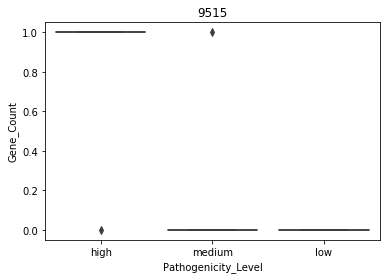

In [14]:
boxplot('9515')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           1                high
1      A_fumigatus_12-750544           1                high
2          A_fumigatus_A1163           1                high
3          A_fumigatus_Af293           1                high
4         A_fumigatus_F16311           1                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           0              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           1                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           1                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           1                 low
15      A_turcosus_HMRAF

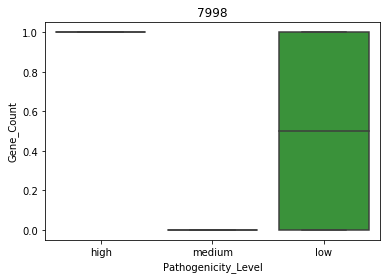

In [15]:
boxplot('7998')

 # The last orthogroup left out of the adjusted p-value list (`7998`) is definitely worse than the last orthogroup included in the adjusted p-value list (`9515`)
  # Use at least a 0.05 cutoff and the adjusted p-value list for further analyses

 # Write a file that is all orthogroups (and the number of genes in each orthogroup) that passed the adjusted p-value ANOVA cutoff

In [16]:
#commenting this out so that I don't add to the file every time I run this notebook
#f = open('Anova_adjP05.txt', "a")
#for k in dAdjP05:
#    f.write(k + "\t" + str(dInt[k]) + "\n")
#f.close()

 ## Removed, `[`,  `]`, and `,` and replaced the spaces with tabs

 # Do a Tukey's Honestly Significantly Different Test (THSDT)

 ## Examples I'm seeing online use NumPy arrays so convert my data to a Pandas dataframe
 ### I think a Pandas dataframe can be used as a NumPy array...

Here is what the data really look like:
                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           5                high
1      A_fumigatus_12-750544           5                high
2          A_fumigatus_A1163           7                high
3          A_fumigatus_Af293           6                high
4         A_fumigatus_F16311           5                high
5        A_lentulus_IFM54703           9              medium
6   A_novofumigatus_IBT16806           9              medium
7        A_udagawae_IFM46973           5              medium
8    A_viridinutans_FRR_0576          11              medium
9    A_thermomutatus_HMRAF39           7              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           2                 low
12  A_cristatus_GZAAS20.1005           4                 low
13        A_fischeri_NRRL181           7                 low
14       A_glaucus_CBS516.65           4     

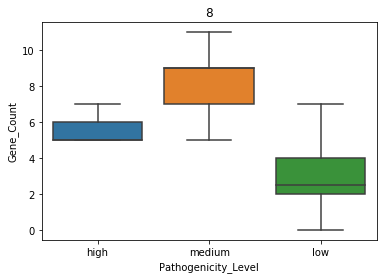

In [17]:
#Here is an example of what the (THSDT) output looks like

#example orthogroup to run the THSD 
orthogroup = '8'

#list that contains the pathogenicity info for each species
pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', \
                 'low', 'low', 'low', 'low', 'low', 'low', 'low']

#list of species in the same order as the pathogenicity list
strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']

#list of the number of genes in each species in the same order as the previous two lists
#uses the dictionary where the numbers are integers
values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
          dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
          dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
          dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]

#make a new dataframe that is each list as a column
dfOrthogroup = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count',\
                                                                                 'Pathogenicity_Level'])

#run the THSDT on the new dataframe
#interested in orthogroups with that have different gene counts when comparing the pathogenicity levels of species
#ie highly pathogenic species have more genes than the other two groups
mc = MultiComparison(dfOrthogroup['Gene_Count'], dfOrthogroup['Pathogenicity_Level']).tukeyhsd()

#organize and print the results of the THSDT
print('Here is what the data really look like:')
boxplot(orthogroup)

print()
print('#######################################################################')
print('This is a table of the Tukey HSD results:')
print()
print(mc)
print()
print('#######################################################################')


print()
print('This is an array of booleans for if we rejected the null hypothesis of no difference between the groups:')
print()
print(mc.reject)
print()
print('Since the result was "False, False, True", this means that high and low are NOT different, high and medium are\
 NOT different, and low vs medium ARE different')
print()
print('#######################################################################')


print()
print('This is an array of the differences between the means of the groups')
print()
print(mc.meandiffs)
print()
print('Since the result was "negative, positive, positive", this means that there were more genes in high than in low, \
fewer genes in high than in medium, and fewer genes in low than in medium')
print('ie. low - high < 0')
print('medium - high > 0')
print('medium - low  > 0')
print()
print()


# Make a function called `tukey` that will count how many orthogroups meet a given criteria and print those orthogroups if desired

In [18]:
#'differences' is a list of booleans for the groups you want in the format of "[True, True, True]"
    #order should be 'high is different than low', 'high is different than medium', 'low is different than medium'
#'matches' is a boolean that says whether or not you want to print all the orthogroups that match your criteria
    #default for matches is set to True
def tukey(differences, matches = True):
    
    #make a counting variable that will contain how many orthogroups met your criteria
    total = 0
    
    #make a list that contains the pathogenicity info
    pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', \
                 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
    #make a list that is the strain names
    strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
    
    #for every orthogroup in the dictionary that has the adjusted p-values that are less than 0.05...
    for orthogroup in dAdjP05:
        #make a list of the number of genes in each species in the same order as the previous two lists 
        values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
          dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
          dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
          dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]
        
        #make a dataframe that is each list as a column
        dfOrthogroup = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count',\
                                                                                 'Pathogenicity_Level'])
        
        #run the THSDT on the dataframe
        mc = MultiComparison(dfOrthogroup['Gene_Count'], dfOrthogroup['Pathogenicity_Level']).tukeyhsd()
        
        #if the user has set "matches" to True,
        if matches:
            
            #and the result of the THSDT matches the user-provided list of booleans,
            if list(mc.reject) == differences:
                #increase the counter by 1
                total += 1
                #and print the orthogroup number you are currently on
                print(str(mc.reject) + orthogroup)
        
        #if the user has not set "matches" to True,
        else:
            #and the result of the THSDT matches the user-provided list of booleans,
            if list(mc.reject) == differences:
                #increase the counter by 1
                total += 1
    #print the total number of orthogroups that matched the user-provided criteria
    print(total)

 ## When finished, comment out the next few boxes because they each take a couple seconds to run

 # How many orthogroups have different numbers of genes in high, middle, and lowly pathogenic species?

In [19]:
tukey([True, True, True], True)

[ True  True  True]5822
[ True  True  True]6949


/Users/MattMead/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:1309: RuntimeWarning: divide by zero encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic
/Users/MattMead/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:1309: RuntimeWarning: invalid value encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic
/Users/MattMead/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:1317: RuntimeWarning: invalid value encountered in greater
  reject = st_range > q_crit


2


 # How many orthogroups have different numbers of genes in high and low and high and medium species, but medium and low species have the same number of genes? 
 ## Ie, how many orthogroups have a different number of genes in highly pathogenic species, but the same number of genes in low and medium pathogenic species?

In [20]:
tukey([True, True, False], True)

[ True  True False]105
[ True  True False]327
[ True  True False]396
[ True  True False]538
[ True  True False]607
[ True  True False]609
[ True  True False]625
[ True  True False]669
[ True  True False]759
[ True  True False]983
[ True  True False]4662
[ True  True False]5379
[ True  True False]6580
[ True  True False]6631
[ True  True False]6966
[ True  True False]6997
[ True  True False]7017
[ True  True False]7031
[ True  True False]7104
[ True  True False]7114
[ True  True False]7250
[ True  True False]7254
[ True  True False]7267
[ True  True False]7302
[ True  True False]7331
[ True  True False]7375
[ True  True False]7383
[ True  True False]7387
[ True  True False]7441
[ True  True False]7515
[ True  True False]7536
[ True  True False]7557
[ True  True False]7564
[ True  True False]7580
[ True  True False]7618
[ True  True False]7635
[ True  True False]7639
[ True  True False]7655
[ True  True False]7659
[ True  True False]7662
[ True  True False]7663
[ True  True False]7769
[ 

 # How many orthogroups have different numbers of genes in high and low and low and medium species, but high and medium species have the same number?
 ## Ie how many orthogroups have the same number of genes in "pathogenic" species (high and medium) but different number of genes in non-pathogenic species (low)?

In [21]:
tukey([True, False, True], True)

[ True False  True]380
[ True False  True]400
[ True False  True]404
[ True False  True]409
[ True False  True]506
[ True False  True]517
[ True False  True]547
[ True False  True]554
[ True False  True]569
[ True False  True]576
[ True False  True]581
[ True False  True]598
[ True False  True]603
[ True False  True]640
[ True False  True]648
[ True False  True]679
[ True False  True]690
[ True False  True]984
[ True False  True]6553
[ True False  True]6863
[ True False  True]6918
[ True False  True]7249
[ True False  True]7270
[ True False  True]7272
[ True False  True]7310
[ True False  True]7316
[ True False  True]7339
[ True False  True]7340
[ True False  True]7365
[ True False  True]7374
[ True False  True]7381
[ True False  True]7393
[ True False  True]7397
[ True False  True]7398
[ True False  True]7402
[ True False  True]7403
[ True False  True]7404
[ True False  True]7406
[ True False  True]7411
[ True False  True]7443
[ True False  True]7445
[ True False  True]7453
[ True Fal

 # How many orthogroups have different numbers of genes in high and medium and low and medium species, but high and low species have the same number of genes?
 ## Ie how many orthogroups have the same number of genes in highly and lowly pathogenic species but a different number of genes in medium-pathogenic species?
 ### Don't know how to think about this group.

In [22]:
tukey([False, True, True], True)

[False  True  True]79
[False  True  True]511
[False  True  True]519
[False  True  True]623
[False  True  True]639
[False  True  True]656
[False  True  True]754
[False  True  True]6649
[False  True  True]6964
[False  True  True]7281
[False  True  True]7950
[False  True  True]8035
[False  True  True]8046
[False  True  True]8222
[False  True  True]8248
[False  True  True]8250
[False  True  True]8261
[False  True  True]8281
[False  True  True]8287
[False  True  True]8290
[False  True  True]8296
[False  True  True]8307
[False  True  True]8320
[False  True  True]8338
[False  True  True]8355
[False  True  True]8378
[False  True  True]8381
[False  True  True]8383
[False  True  True]8391
[False  True  True]8393
[False  True  True]8398
[False  True  True]8404
[False  True  True]8405
[False  True  True]8425
[False  True  True]8427
[False  True  True]8429
[False  True  True]8430
[False  True  True]8435
[False  True  True]8438
[False  True  True]8439
[False  True  True]8451
[False  True  True]8467


 # How many orthogroups have different numbers of genes in high and low  species, but the same number of genes in high and medium and low and medium species?
 ## An explanation for this scenario is that there is a high variance in the number of genes in medium pathogenicity species

In [23]:
tukey([True, False, False], True)

[ True False False]48
1


 # How many orthogroups have different numbers of genes in high and medium  species, but the same number of genes in high and low and low and medium species?
 ## An explanation for this scenario is that there is a high variance in the number of genes in low pathogenicity species

In [24]:
tukey([False, True, False], True)

[False  True False]7534
[False  True False]7648
[False  True False]7998
[False  True False]7999
[False  True False]8000
[False  True False]8004
[False  True False]8012
[False  True False]8027
[False  True False]8036
[False  True False]8039
[False  True False]8048
[False  True False]8055
[False  True False]8056
[False  True False]8059
[False  True False]8064
[False  True False]8085
[False  True False]8090
[False  True False]8092
[False  True False]8100
[False  True False]8117
[False  True False]8122
[False  True False]8124
[False  True False]8169
[False  True False]8174
[False  True False]8184
25


 # How many orthogroups have different numbers of genes in low and medium  species, but the same number of genes in high and low and high and medium species?
 ## An explanation for this scenario is that there is a high variance in the number of genes in highly pathogenic species

In [25]:
tukey([False, False, True], True)

[False False  True]8
1


 # How many orthogroups all have the same number of genes in them?
 ## This number should be zero since the input for this is a dataframe of only those orhogroups that were identified in the ANOVA

In [26]:
tukey([False, False, False], False)

0


 # Further investigate orthogroups 5822 and 6949
 ## The only two orthogroups that has different numbers of genes in each of the three sets of species

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           2              medium
6   A_novofumigatus_IBT16806           2              medium
7        A_udagawae_IFM46973           2              medium
8    A_viridinutans_FRR_0576           2              medium
9    A_thermomutatus_HMRAF39           2              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           1                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           2                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

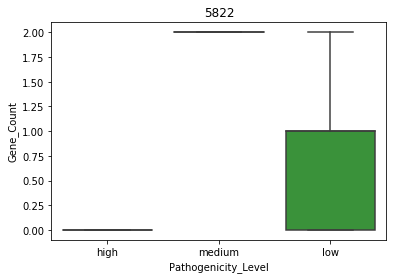

In [27]:
boxplot('5822')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           1              medium
6   A_novofumigatus_IBT16806           2              medium
7        A_udagawae_IFM46973           1              medium
8    A_viridinutans_FRR_0576           2              medium
9    A_thermomutatus_HMRAF39           1              medium
10            A_cejpii_FS110           1                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           1                 low
13        A_fischeri_NRRL181           1                 low
14       A_glaucus_CBS516.65           1                 low
15      A_turcosus_HMRAF

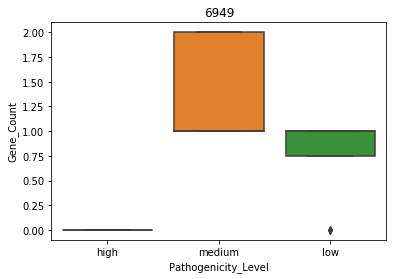

In [28]:
boxplot('6949')

 ## Neither of these orthogroups have interesting presence/absence patterns other than they are missing in A. fumigatus

 ### Move on and don't talk about them much in the manuscript

 # Of the orthogroups in the "A. fumigatus-specific contractions/expansion" (`[True, True, False]`) list, 

 ## How many have MORE genes in A. fumigatus

 ### Commenting this out because it takes awhile to run

In [29]:
#make a counting variable that will contain how many orthogroups met your criteria
total = 0
    
#make a list that contains the pathogenicity info
pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', \
                 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
#make a list that is the strain names
strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
          'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
          'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
          'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
          'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
    
#for every orthogroup in the dictionary that has the adjusted p-values that are less than 0.05...
for orthogroup in dAdjP05:
    #make a list of the number of genes in each species in the same order as the previous two lists 
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
        dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
        dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
        dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]
        
    #make a dataframe that is each list as a column
    dfOrthogroup = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count',\
                                                                                 'Pathogenicity_Level'])
        
    #run the THSDT on the dataframe
    mc = MultiComparison(dfOrthogroup['Gene_Count'], dfOrthogroup['Pathogenicity_Level']).tukeyhsd()
        
    #if the result of the THSDT matches the user-provided list of booleans,
    if list(mc.reject) == [True, True, False] and mc.meandiffs[0] < 0 and mc.meandiffs[1] < 0:
        #increase the counter by 1
        total += 1
        print(orthogroup)
        
#print the total number of orthogroups that matched the user-provided criteria
print(total)

105
538
607
609
625
759
983
4662
5379


/Users/MattMead/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:1309: RuntimeWarning: divide by zero encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic
/Users/MattMead/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:1309: RuntimeWarning: invalid value encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic
/Users/MattMead/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:1317: RuntimeWarning: invalid value encountered in greater
  reject = st_range > q_crit


7114
7250
7441
7917
8057
8132
8246
8304
8318
8347
8348
8366
8483
8484
8486
8491
8513
8524
8549
8606
8631
8644
8645
8646
8648
8651
8655
8657
8658
8669
8671
8672
8673
8682
8684
8686
8687
8690
8693
8700
8709
8713
8714
8720
8725
8726
8727
8729
8730
8732
8734
8735
8740
8741
8885
8886
8887
8950
8957
8970
8971
8975
8981
8987
8989
8991
8996
8997
8998
9005
9011
9019
9025
9027
9028
9034
9035
9036
9037
9038
9039
9040
9042
9043
9047
9048
9049
9050
9051
9052
9053
9054
9056
9057
9058
9060
9061
9062
9063
9064
9065
9444
9445
9446
9447
9448
9449
9450
9451
9453
9455
9456
9457
9458
9459
9460
9462
9463
9464
9467
9468
9469
9470
9471
9472
9473
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9517
9518
9519
9521
9523
9525
9526
9527
9528
9529
9530
9531
9532
10015
10022
10023
10024
10025
10026
10029
10030
10031
10032
10033
10035
10036
10040
10041
10043
10045
10046
10

 ## How many have FEWER genes in A. fumigatus

 ### Commenting this out because it takes awhile to run

In [30]:
#make a counting variable that will contain how many orthogroups met your criteria
total = 0
    
#make a list that contains the pathogenicity info
pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', \
                 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
#make a list that is the strain names
strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
    
#for every orthogroup in the dictionary that has the adjusted p-values that are less than 0.05...
for orthogroup in dAdjP05:
    #make a list of the number of genes in each species in the same order as the previous two lists 
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
        dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
        dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
        dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]
        
    #make a dataframe that is each list as a column
    dfOrthogroup = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count',\
                                                                                 'Pathogenicity_Level'])
        
    #run the THSDT on the dataframe
    mc = MultiComparison(dfOrthogroup['Gene_Count'], dfOrthogroup['Pathogenicity_Level']).tukeyhsd()
        
    #if the result of the THSDT matches the user-provided list of booleans,
    if list(mc.reject) == [True, True, False] and mc.meandiffs[0] > 0 and mc.meandiffs[1] > 0:
        #increase the counter by 1
        total += 1
        print(orthogroup)
        
#print the total number of orthogroups that matched the user-provided criteria
print(total)

327
396
669
6580
6631
6966
6997
7017
7031
7104
7254
7267
7302
7331
7375
7383
7387
7515
7536
7557
7564
7580
7618
7635
7639
7655
7659
7662
7663
7769
7780
7800
7807
7813
7821
7870
7897
7898
38


 # Of the orthogroups in the "Pathogen-specific contractions/expansion" (`[True, False, True]`) list, 

 ## How many have MORE genes in pathogens

 ### Commenting this out because it takes awhile to run

In [31]:
#make a counting variable that will contain how many orthogroups met your criteria
total = 0
    
#make a list that contains the pathogenicity info
pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', \
                 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
#make a list that is the strain names
strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
    
#for every orthogroup in the dictionary that has the adjusted p-values that are less than 0.05...
for orthogroup in dAdjP05:
    #make a list of the number of genes in each species in the same order as the previous two lists 
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
        dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
        dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
        dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]
        
    #make a dataframe that is each list as a column
    dfOrthogroup = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count',\
                                                                                 'Pathogenicity_Level'])
        
    #run the THSDT on the dataframe
    mc = MultiComparison(dfOrthogroup['Gene_Count'], dfOrthogroup['Pathogenicity_Level']).tukeyhsd()
        
    #if the result of the THSDT matches the user-provided list of booleans,
    if list(mc.reject) == [True, False, True] and mc.meandiffs[0] < 0 and mc.meandiffs[2] > 0:
        #increase the counter by 1
        total += 1
        print(orthogroup)
        
        
#print the total number of orthogroups that matched the user-provided criteria
print(total)

380
400
404
409
506
547
554
569
576
581
598
603
640
648
679
690
984
6553
6863
6918
7249
7270
7272
7310
7316
7339
7340
7365
7374
7381
7393
7397
7398
7402
7403
7404
7406
7411
7443
7445
7453
7459
7462
7470
7475
7480
7483
7484
7494
7512
7513
7680
7684
7688
7694
7699
7701
7702
7703
7706
7707
7708
7710
7712
7716
7721
7722
7723
7726
7735
7736
7748
7837
7903
7904
7908
7911
7919
7920
7921
7922
7923
7925
7928
7929
7931
7933
7938
7939
7941
7945
7951
7952
7954
7960
7961
7963
7965
7966
7967
7968
7969
7972
7980
8195
8472
8476
8480
8481
8485
110


 ## How many have FEWER genes in pathogens

In [32]:
#make a counting variable that will contain how many orthogroups met your criteria
total = 0
    
#make a list that contains the pathogenicity info
pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', \
                 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
#make a list that is the strain names
strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
    
#for every orthogroup in the dictionary that has the adjusted p-values that are less than 0.05...
for orthogroup in dAdjP05:
    #make a list of the number of genes in each species in the same order as the previous two lists 
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
        dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
        dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
        dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]
        
    #make a dataframe that is each list as a column
    dfOrthogroup = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count',\
                                                                                 'Pathogenicity_Level'])
        
    #run the THSDT on the dataframe
    mc = MultiComparison(dfOrthogroup['Gene_Count'], dfOrthogroup['Pathogenicity_Level']).tukeyhsd()
        
    #if the result of the THSDT matches the user-provided list of booleans,
    if list(mc.reject) == [True, False, True] and mc.meandiffs[0] > 0 and mc.meandiffs[2] < 0:
        #increase the counter by 1
        total += 1
        print(orthogroup)
        
#print the total number of orthogroups that matched the user-provided criteria
print(total)

517
7777
8022
8096
8227
8249
8495
8875
8


# Make a function called "dotplot" that will show the number of family members in a given orthogroup

In [33]:
#orthogroup will be the only parameter
def dotplot(orthogroup):
    #make a list that is the pathogenicity levels of the species in the order that they will be in the dataframe
    pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium',\
                 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
    #make a list that is the strains
    strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
              
    
    #make a list of the gene counts in the same order as the pathogenicity list
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
          dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
          dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
              dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]

    #make a pandas dataframe with strain, Gene_Count, and a Pathogenicity_Level column
    df = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count','Pathogenicity_Level'])
    
    print(df)
    
    sns.swarmplot(x="Pathogenicity_Level", y="Gene_Count", data=df, size=10).set_title(orthogroup);

# Make a function called "dotplot_save" that will save an image of the dotplot

In [34]:
#orthogroup will be the only parameter
def dotplot_save(orthogroup):
    #make a list that is the pathogenicity levels of the species in the order that they will be in the dataframe
    pathogenicity = ['high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium',\
                 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low']
    
    #make a list that is the strains
    strain = ['A_neoellipticus_NRRL5109', 'A_fumigatus_12-750544', 'A_fumigatus_A1163', 'A_fumigatus_Af293', \
              'A_fumigatus_F16311', 'A_lentulus_IFM54703', 'A_novofumigatus_IBT16806', 'A_udagawae_IFM46973', \
              'A_viridinutans_FRR_0576', 'A_thermomutatus_HMRAF39', 'A_cejpii_FS110', 'A_clavatus_NRRL1', \
              'A_cristatus_GZAAS20.1005', 'A_fischeri_NRRL181', 'A_glaucus_CBS516.65', 'A_turcosus_HMRAF1038', \
              'A_turcosus_HMRAF23', 'A_wentii_DTO134E9']
              
    
    #make a list of the gene counts in the same order as the pathogenicity list
    values = [dInt[orthogroup][1], dInt[orthogroup][5], dInt[orthogroup][6], dInt[orthogroup][7], dInt[orthogroup][8], \
          dInt[orthogroup][10], dInt[orthogroup][11], dInt[orthogroup][12], dInt[orthogroup][15], dInt[orthogroup][16], \
          dInt[orthogroup][0], dInt[orthogroup][2], dInt[orthogroup][3], dInt[orthogroup][4], dInt[orthogroup][9], \
              dInt[orthogroup][13], dInt[orthogroup][14], dInt[orthogroup][17]]

    #make a pandas dataframe with strain, Gene_Count, and a Pathogenicity_Level column
    df = pd.DataFrame(list(zip(strain, values, pathogenicity)), columns = ['Strain', 'Gene_Count','Pathogenicity_Level'])
    
    sns.swarmplot(x="Pathogenicity_Level", y="Gene_Count", data=df, size=10).set_title(orthogroup)
    
    plt.savefig(orthogroup +'.pdf')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           2                high
1      A_fumigatus_12-750544           2                high
2          A_fumigatus_A1163           2                high
3          A_fumigatus_Af293           2                high
4         A_fumigatus_F16311           2                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           0              medium
9    A_thermomutatus_HMRAF39           1              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           1                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

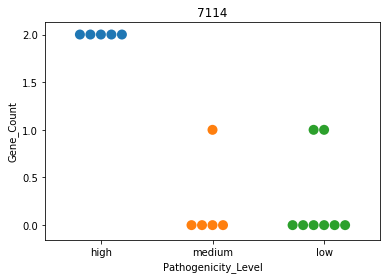

In [35]:
dotplot('7114')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           1              medium
6   A_novofumigatus_IBT16806           1              medium
7        A_udagawae_IFM46973           1              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           2              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

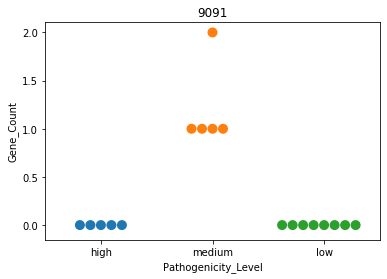

In [36]:
dotplot('9091')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           1                high
1      A_fumigatus_12-750544           1                high
2          A_fumigatus_A1163           2                high
3          A_fumigatus_Af293           1                high
4         A_fumigatus_F16311           1                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           0              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

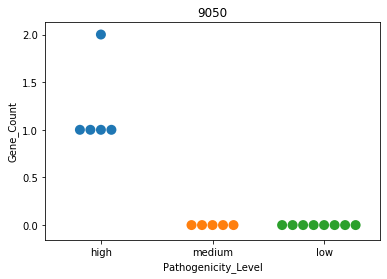

In [37]:
dotplot('9050')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           2                high
1      A_fumigatus_12-750544           1                high
2          A_fumigatus_A1163           1                high
3          A_fumigatus_Af293           1                high
4         A_fumigatus_F16311           1                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           0              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

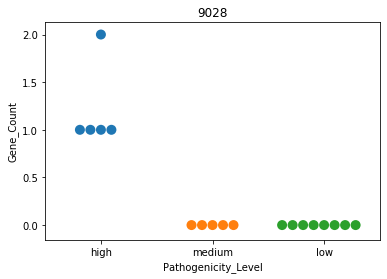

In [38]:
dotplot('9028')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           1              medium
6   A_novofumigatus_IBT16806           1              medium
7        A_udagawae_IFM46973           1              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           1              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

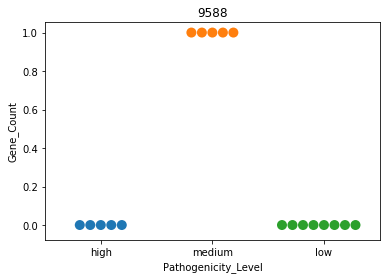

In [39]:
dotplot('9588')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           1              medium
6   A_novofumigatus_IBT16806           1              medium
7        A_udagawae_IFM46973           1              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           1              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

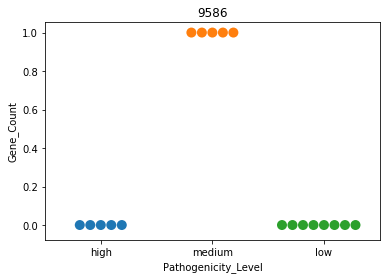

In [40]:
dotplot('9586')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           1                high
1      A_fumigatus_12-750544           1                high
2          A_fumigatus_A1163           1                high
3          A_fumigatus_Af293           1                high
4         A_fumigatus_F16311           1                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           0              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

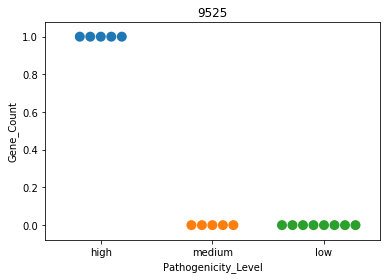

In [41]:
dotplot('9525')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           0              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           1                 low
11          A_clavatus_NRRL1           1                 low
12  A_cristatus_GZAAS20.1005           1                 low
13        A_fischeri_NRRL181           1                 low
14       A_glaucus_CBS516.65           1                 low
15      A_turcosus_HMRAF

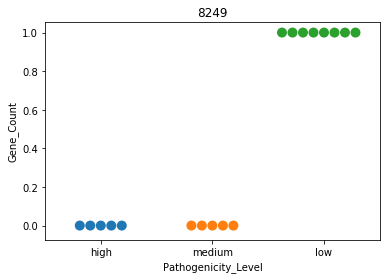

In [42]:
dotplot('8249')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           1              medium
6   A_novofumigatus_IBT16806           1              medium
7        A_udagawae_IFM46973           1              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           1              medium
10            A_cejpii_FS110           1                 low
11          A_clavatus_NRRL1           1                 low
12  A_cristatus_GZAAS20.1005           1                 low
13        A_fischeri_NRRL181           1                 low
14       A_glaucus_CBS516.65           1                 low
15      A_turcosus_HMRAF

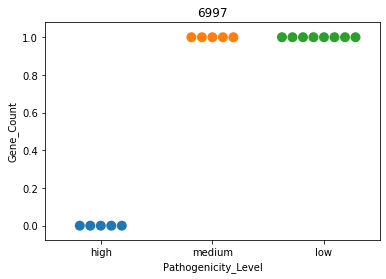

In [43]:
dotplot('6997')

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           1                high
1      A_fumigatus_12-750544           1                high
2          A_fumigatus_A1163           1                high
3          A_fumigatus_Af293           1                high
4         A_fumigatus_F16311           1                high
5        A_lentulus_IFM54703           0              medium
6   A_novofumigatus_IBT16806           0              medium
7        A_udagawae_IFM46973           0              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           0              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           0                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

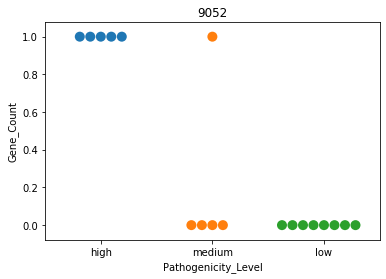

                      Strain  Gene_Count Pathogenicity_Level
0   A_neoellipticus_NRRL5109           0                high
1      A_fumigatus_12-750544           0                high
2          A_fumigatus_A1163           0                high
3          A_fumigatus_Af293           0                high
4         A_fumigatus_F16311           0                high
5        A_lentulus_IFM54703           1              medium
6   A_novofumigatus_IBT16806           1              medium
7        A_udagawae_IFM46973           1              medium
8    A_viridinutans_FRR_0576           1              medium
9    A_thermomutatus_HMRAF39           1              medium
10            A_cejpii_FS110           0                 low
11          A_clavatus_NRRL1           0                 low
12  A_cristatus_GZAAS20.1005           0                 low
13        A_fischeri_NRRL181           1                 low
14       A_glaucus_CBS516.65           0                 low
15      A_turcosus_HMRAF

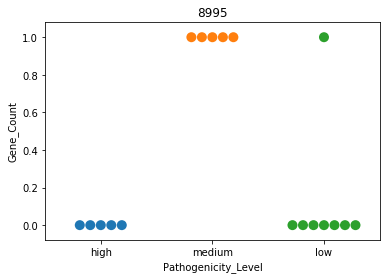